<a href="https://colab.research.google.com/github/Bhuvanachandra-kusuma/unet-breast-ultrasound-segmentation/blob/main/Unet_brest_ultrasound_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 77% 151M/195M [00:00<00:00, 1.58GB/s]
100% 195M/195M [00:00<00:00, 1.01GB/s]


In [ ]:
!unzip breast-ultrasound-images-dataset.zip


Archive:  breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Data

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
DATA_PATH = "/content/Dataset_BUSI_with_GT"
IMG_SIZE = 128
BATCH_SIZE = 4

image_paths = []
mask_paths = []

for class_name in os.listdir(DATA_PATH):
    class_folder = os.path.join(DATA_PATH, class_name)

    for file in os.listdir(class_folder):
        if "_mask" not in file:
            image_paths.append(os.path.join(class_folder, file))
            mask_paths.append(os.path.join(class_folder, file.replace(".png", "_mask.png")))

print("Total Images:", len(image_paths))


Total Images: 780


In [ ]:
def preprocess(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.shuffle(500)
dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

print("Dataset Ready")


Dataset Ready


In [ ]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)

    # Bridge
    c5 = conv_block(p4, 512)

    # Decoder
    u6 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c9)

    return Model(inputs, outputs)

model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=dice_loss,
    metrics=[dice_coef]
)


In [ ]:
history = model.fit(
    dataset,
    epochs=10
)


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - dice_coef: 0.1815 - loss: 0.8185
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - dice_coef: 0.2638 - loss: 0.7362
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - dice_coef: 0.3302 - loss: 0.6698
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - dice_coef: 0.3606 - loss: 0.6394
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - dice_coef: 0.3895 - loss: 0.6105
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - dice_coef: 0.4388 - loss: 0.5612
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - dice_coef: 0.4592 - loss: 0.5408
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - dice_coef: 0.5076 - loss: 0.4924
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - dice_coef: 0.5687 - loss: 0.4313
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - dice_coef: 0.6185 - loss: 0.3815


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


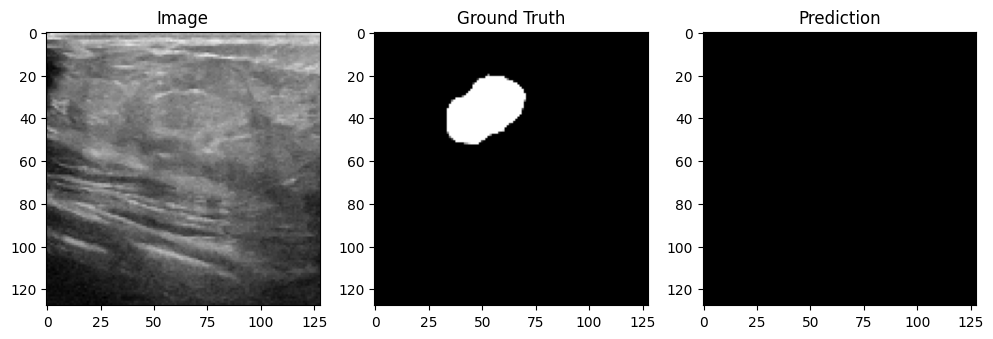

In [ ]:
import numpy as np

for images, masks in dataset.take(1):
    preds = model.predict(images)

    plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(masks[0].numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(preds[0].squeeze() > 0.5, cmap='gray')
    plt.title("Prediction")

    plt.show()
    break


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef]
)


In [ ]:
history = model.fit(
    dataset,
    epochs=30
)


Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - dice_coef: 0.6171 - loss: 0.5377
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - dice_coef: 0.6569 - loss: 0.4595
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - dice_coef: 0.6978 - loss: 0.3877
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - dice_coef: 0.7291 - loss: 0.3419
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - dice_coef: 0.7334 - loss: 0.3413
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - dice_coef: 0.7584 - loss: 0.3064
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - dice_coef: 0.7940 - loss: 0.2703
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - dice_coef: 0.8209 - loss: 0.2325
Epoch 9/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - dice_coef: 0.8176 - loss: 0.2398
Epoch 10/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - dice_coef: 0.8224 - loss: 0.2316
Epoch 11/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - dice_coef: 0.8307 - loss: 0.2218
Epoch 12/30
195/195 ━━━━━

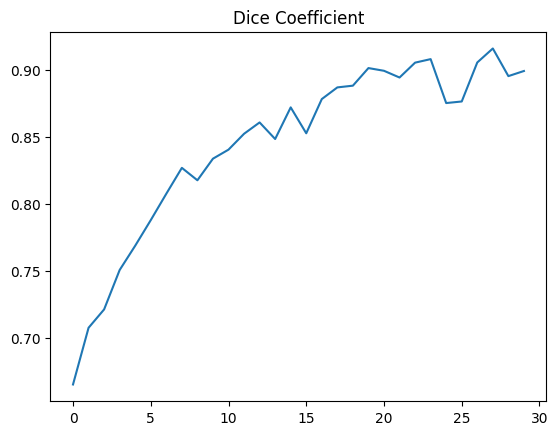

In [ ]:
plt.plot(history.history['dice_coef'])
plt.title("Dice Coefficient")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


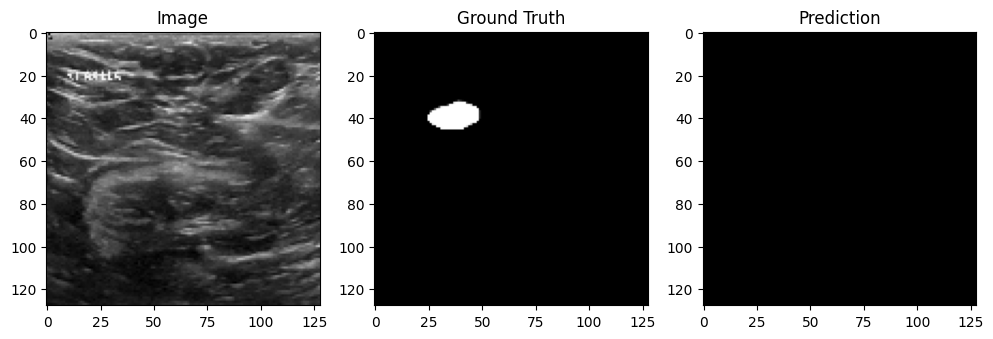

In [ ]:
import numpy as np

for images, masks in dataset.take(1):
    preds = model.predict(images)

    plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(masks[0].numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(preds[0].squeeze() > 0.5, cmap='gray')
    plt.title("Prediction")

    plt.show()
    break


In [ ]:
for images, masks in dataset.take(1):
    preds = model.predict(images)
    print("Min prediction:", preds.min())
    print("Max prediction:", preds.max())
    break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Min prediction: 4.1843045e-06
Max prediction: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


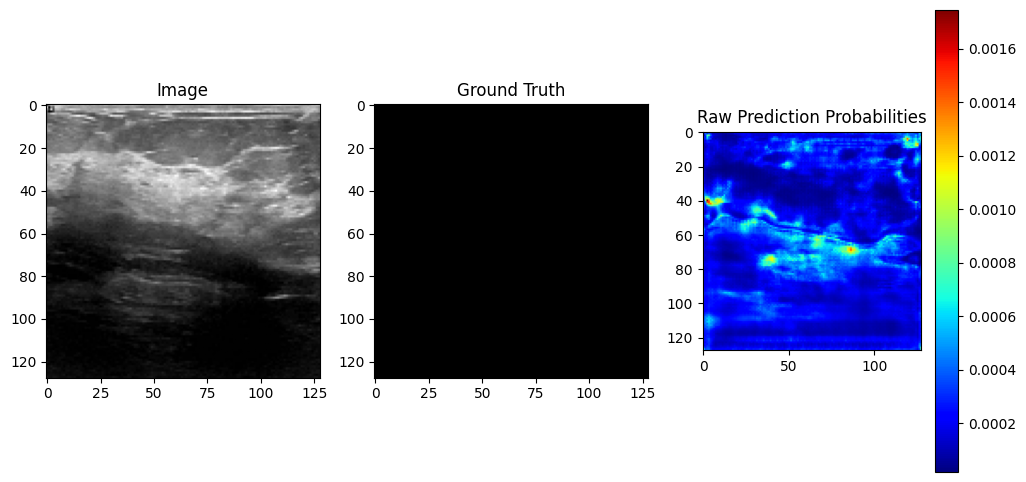

In [ ]:
for images, masks in dataset.take(1):
    preds = model.predict(images)

    plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(masks[0].numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(preds[0].squeeze(), cmap='jet')
    plt.colorbar()
    plt.title("Raw Prediction Probabilities")

    plt.show()
    break


In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Threshold predictions at 0.5
    y_pred_f = tf.cast(y_pred_f > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_coef]
)


In [ ]:
history = model.fit(dataset, epochs=10)


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - dice_coef: 0.9034 - iou_coef: 0.8568 - loss: 0.1241
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - dice_coef: 0.9074 - iou_coef: 0.8596 - loss: 0.1282
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - dice_coef: 0.9194 - iou_coef: 0.8752 - loss: 0.1073
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - dice_coef: 0.9252 - iou_coef: 0.8885 - loss: 0.0947
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - dice_coef: 0.9303 - iou_coef: 0.8894 - loss: 0.0941
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - dice_coef: 0.9203 - iou_coef: 0.8762 - loss: 0.1047
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - dice_coef: 0.9342 - iou_coef: 0.8949 - loss: 0.0883
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - dice_coef: 0.9374 - iou_coef: 0.9004 - loss: 0.0825
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - dice_coef: 0.9331 - iou_coef: 0.8913 - loss: 0.0901
Epoch 10/10
195/195 ━━━━━━━━━━━━━━

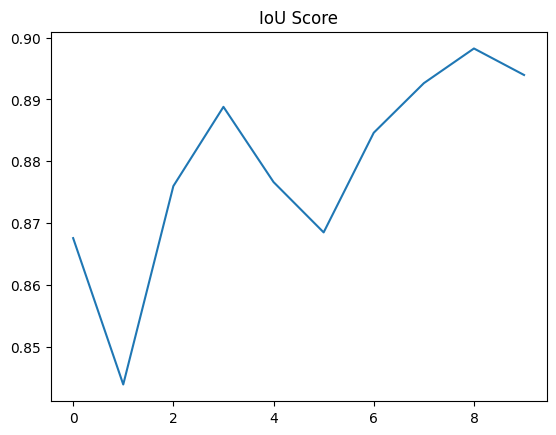

In [ ]:
plt.plot(history.history['iou_coef'])
plt.title("IoU Score")
plt.show()
